In [2]:
import csv

import numpy as np
import rasterio
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [3]:
dataset = rasterio.open("./data/crs.tiff")
img_data = dataset.read(1)

In [4]:
with open('training/data_bin.csv', 'r') as f:
    reader = csv.DictReader(f)
    labeled_coords = [r for r in reader]
print("labeled dataset contains {} points".format(len(labeled_coords)))

labeled dataset contains 115 points


In [5]:
block_size = 32


def get_satellite_raw_uint8(coord):
    x, y = dataset.index(float(coord['lon']), float(coord['lat']))
    img = img_data[x - block_size // 2:x + block_size // 2, y - block_size // 2:y + block_size // 2]
    img = (img / np.max(img) * 255).astype(np.uint8)
    return img

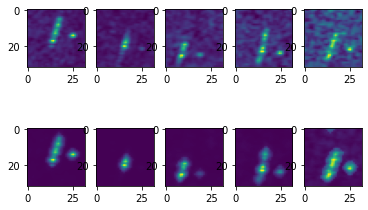

In [6]:
from matplotlib import pyplot as plt
from cv2 import cv2 as cv

f, axarr = plt.subplots(2, 5)
plt.rcParams['figure.figsize'] = [15, 5]

kernel1 = np.ones((3, 3), np.float32) / 25
kernel2 = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3, 3))


def remove_noise_satellite(img):
    mask = img / 16
    mask = np.power(mask, 2)
    mask = cv.filter2D(mask, -1, kernel1)
    avg_val = np.average(mask) + 10
    mask[mask < avg_val] = np.multiply(mask[mask < avg_val], 0.5)
    mask = cv.dilate(mask, kernel2, iterations=2)
    img = np.copy(img) * mask.astype(np.float32)
    img *= 255.0 / img.max()
    return img


for i in range(5):
    im_pre = get_satellite_raw_uint8(labeled_coords[75 + i])

    im = remove_noise_satellite(im_pre)
    axarr[0, i].imshow(im_pre)
    axarr[1, i].imshow(im)

In [7]:
def get_filtered_satellite_float32(coord):
    img = get_satellite_raw_uint8(coord)
    img = remove_noise_satellite(img) / 255.0
    img = np.expand_dims(img, -1)
    return img

In [8]:
X = list(map(get_filtered_satellite_float32, labeled_coords))
Y = [int(l['windmill']) for l in labeled_coords]

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

X_train = np.stack(X_train)
X_test = np.stack(X_test)
Y_train = keras.utils.to_categorical(Y_train, 2)
Y_test = keras.utils.to_categorical(Y_test, 2)

In [10]:
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2021-11-06 16:00:23.540006: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-06 16:00:23.548669: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rudolf/Projects/cs-ml-windmill/venv/lib/python3.9/site-packages/cv2/../../lib64:
2021-11-06 16:00:23.548692: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-11-06 16:00:23.549208: I tensorflow/core/platform/cpu_

In [11]:
model.fit(X_train, Y_train, epochs=5)

2021-11-06 16:00:24.328541: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
3/3 [==============================] - 0s 22ms/step - loss: 0.6826 - accuracy: 0.6500
Epoch 2/5
3/3 [==============================] - 0s 11ms/step - loss: 0.5991 - accuracy: 0.7000
Epoch 3/5
3/3 [==============================] - 0s 11ms/step - loss: 0.5377 - accuracy: 0.6625
Epoch 4/5
3/3 [==============================] - 0s 10ms/step - loss: 0.5012 - accuracy: 0.6750
Epoch 5/5
3/3 [==============================] - 0s 9ms/step - loss: 0.4621 - accuracy: 0.7750


In [12]:
model.evaluate(X_test, Y_test, verbose=2)

2/2 - 0s - loss: 0.4165 - accuracy: 0.7429


[0.4165387451648712, 0.7428571581840515]